# ARIMA Model (JP Morgan Chase)

#### Import Libraries and Download Data


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download JP Morgan Chase stock data from Yahoo Finance
ticker = "JPM"
data = yf.download(ticker, start="2020-01-01", end="2024-01-01")
data = data['Close']  # Focus on the closing prices
data = data.resample('D').mean()  # Resample to daily frequency
data.fillna(method='ffill', inplace=True)  # Forward fill missing values

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-7e100d3737d4>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values


#### Visualize the Data

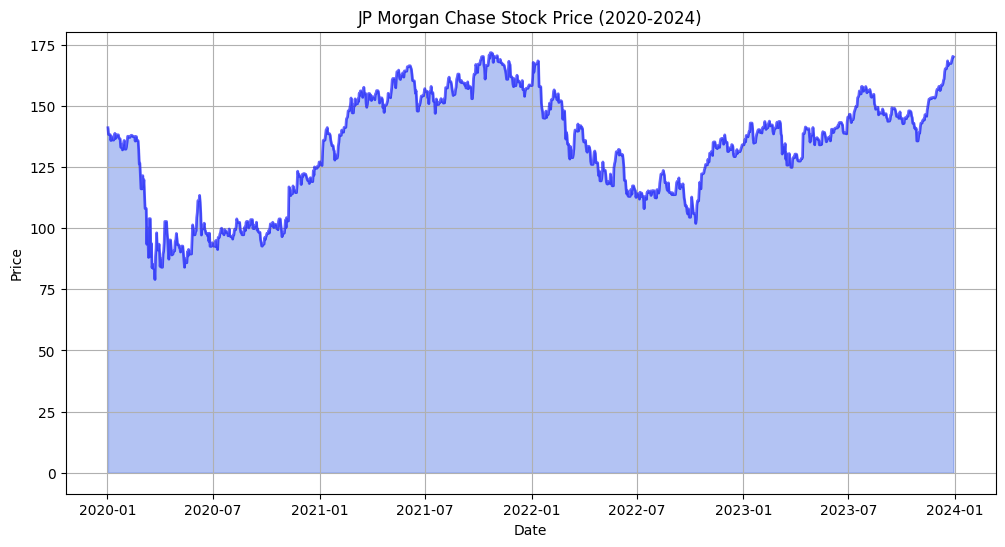

In [ ]:
plt.figure(figsize=(12, 6))
plt.fill_between(data.index, data, color='royalblue', alpha=0.4)
plt.plot(data, color='blue', alpha=0.6, linewidth=2)
plt.title('JP Morgan Chase Stock Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


#### Data Split Training and testing

In [ ]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

#### 11

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

data_diff = data.diff().dropna()

# Check stationarity again
print('Check stationarity again')
result = adfuller(data_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.4641626105365726
p-value: 0.5511592781018051
Check stationarity again
ADF Statistic: -9.797994651574621
p-value: 6.101151890427532e-17


#### Identify ARIMA Parameters


Use the ACF and PACF plots to identify the order of ARIMA (p, d, q).

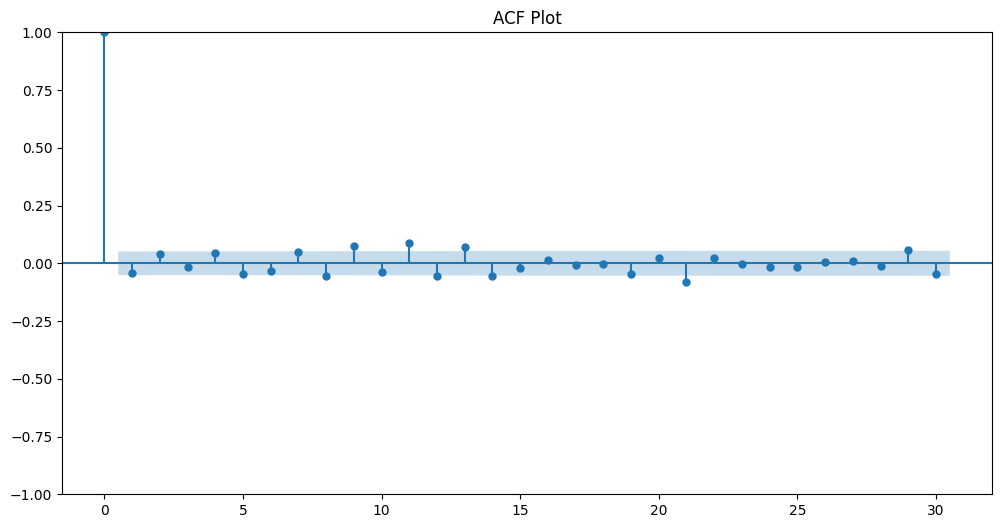

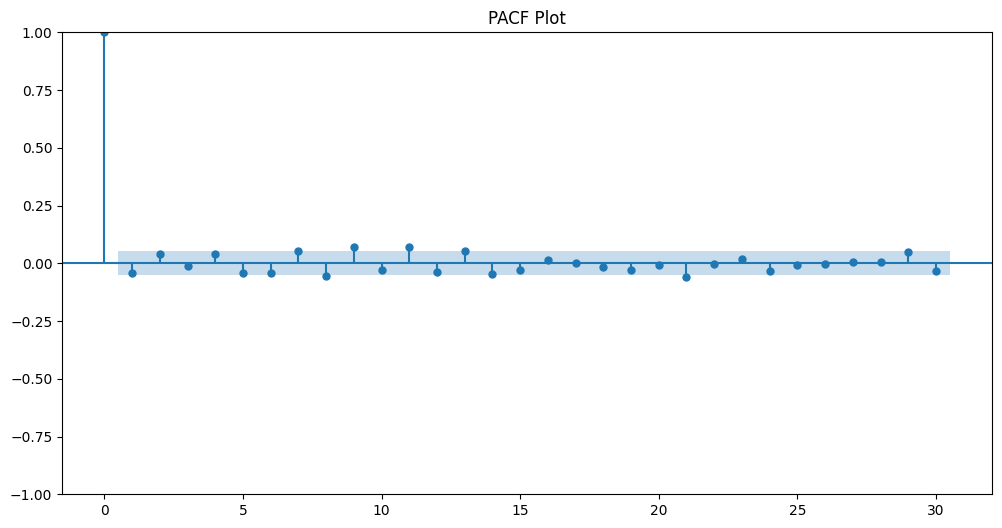

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(data_diff, lags=30, ax=plt.gca())
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(data_diff, lags=30, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

#### Fit the ARIMA Model

Choose the values of p, d, and q based on the ACF and PACF plots, and fit the model:



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Set the order based on ACF and PACF results, e.g., (p=1, d=1, q=1)
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3125.140
Date:                Mon, 23 Sep 2024   AIC                           6256.281
Time:                        22:02:40   BIC                           6272.133
Sample:                    01-02-2020   HQIC                          6262.195
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5962      0.143     -4.157      0.000      -0.877      -0.315
ma.L1          0.5458      0.151      3.607      0.000       0.249       0.842
sigma2         4.2714      0.067     63.482      0.0

#### Make Predictions

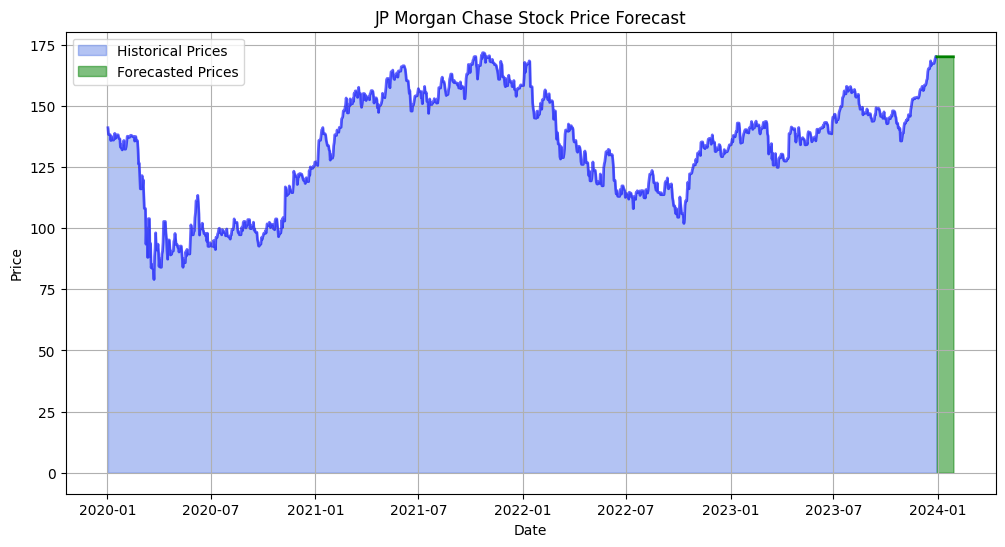

In [ ]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_series = pd.Series(forecast, index=forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.fill_between(data.index, data, color='royalblue', alpha=0.4, label='Historical Prices')
plt.fill_between(forecast_series.index, forecast_series, color='green', alpha=0.5, label='Forecasted Prices')
plt.plot(data, color='blue', alpha=0.6, linewidth=2)
plt.plot(forecast_series, color='green', linewidth=2)
plt.title('JP Morgan Chase Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()




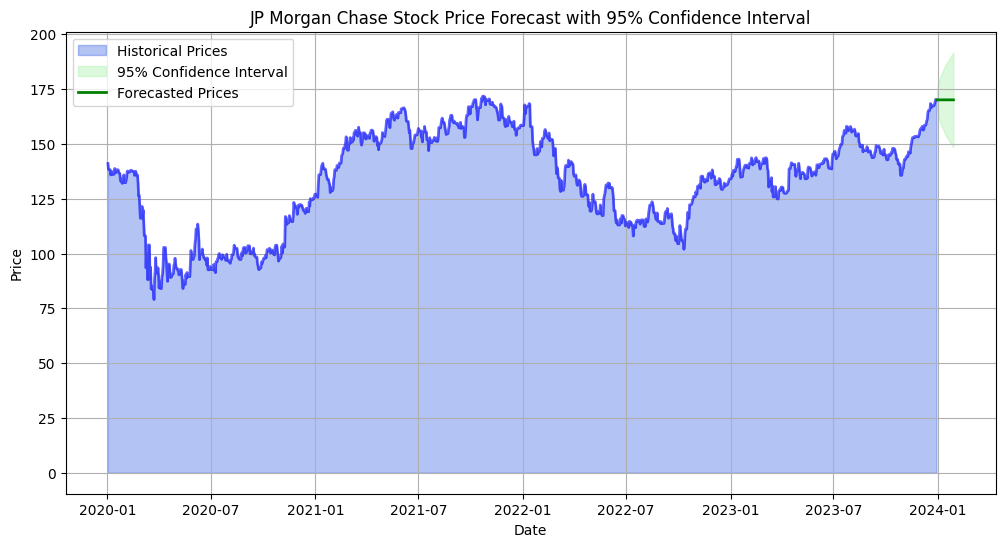

In [ ]:
# Forecast the next 30 days and get confidence intervals
forecast_obj = model_fit.get_forecast(steps=30)
forecast_df = forecast_obj.summary_frame()  # This returns a DataFrame with forecast, stderr, and confidence intervals

# Extract the forecasted values and confidence intervals
forecast_series = forecast_df['mean']
lower_series = forecast_df['mean_ci_lower']  # Lower bound of the 95% confidence interval
upper_series = forecast_df['mean_ci_upper']  # Upper bound of the 95% confidence interval

# Create the index for the forecasted dates
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_series.index = forecast_index
lower_series.index = forecast_index
upper_series.index = forecast_index

# Plot the results
plt.figure(figsize=(12, 6))
plt.fill_between(data.index, data, color='royalblue', alpha=0.4, label='Historical Prices')
plt.plot(data, color='blue', alpha=0.6, linewidth=2)

# Plot the forecast and the confidence intervals
plt.fill_between(forecast_series.index, lower_series, upper_series, color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.plot(forecast_series, color='green', linewidth=2, label='Forecasted Prices')

plt.title('JP Morgan Chase Stock Price Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()



#### Model Evaluation


Evaluate the model using metrics like MSE, RMSE, or MAE



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions for the test set using the fitted model
predictions = model_fit.forecast(steps=len(test))
predictions_index = test.index
predictions_series = pd.Series(predictions, index=predictions_index)

# Calculate evaluation metrics
mse = np.mean((predictions_series - test) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_series - test))

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Squared Error (MSE): nan
Root Mean Squared Error (RMSE): nan
Mean Absolute Error (MAE): nan
